In [1]:
import sqlite3
import pandas as pd
from lightgbmlss.model import *
from lightgbmlss.distributions.Weibull import *
import lightgbm as lgb
import numpy as np
from lightgbmlss.distributions.Gaussian import *
from lightgbmlss.distributions.Mixture import *
from lightgbmlss.distributions.mixture_distribution_utils import MixtureDistributionClass

from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
figure_size = (10,5)
import plotnine
from plotnine import *
plotnine.options.figure_size = figure_size

conn = sqlite3.connect('../../data/nfp2/nfp2.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

data_df_clean = data_df[data_df['convergence'] == 1]
data_df_clean = data_df_clean.dropna(subset=['quasisymmetry'])


X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = np.log(data_df_clean['quasisymmetry'])

features_no_outliers, test_features_no_outliers, target_no_outliers, test_target_no_outliers = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create the Dataset with max_bin parameter specified
dtrain = lgb.Dataset(features_no_outliers, label=target_no_outliers.values)

In [2]:
from lightgbmlss.model import LightGBMLSS  # Ensure this import matches your actual usage

lgblss = LightGBMLSS(
    Mixture(
        Gaussian(response_fn="exp", stabilization="L2"), 
        M = 9,
        tau=1.0,
        hessian_mode="individual",
    )
)

opt_params = {
    "max_depth": 12,
    "num_leaves": 28,
    "min_data_in_leaf": 1301,
    "min_gain_to_split": 0.4319605082782415,
    "min_sum_hessian_in_leaf": 0.30164458790087806,
    "subsample": 0.8580461591753848,
    "subsample_freq": 17,
    "feature_fraction": 0.9625238100384692,
    "boosting_type": "goss",
    "learning_rate": 0.32940258973561587,
    "max_delta_step": 0.3796994086587884,
    "feature_pre_filter": False,
    "boosting": "dart",  # Assuming this value remains the same
    "opt_rounds": 200  # Assuming this value remains the same
}


n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

lgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

print("Model trained successfully")

# Seed for reproducibility in torch operations
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 10000  # Use the number of rows in X_test as the number of samples

# Quantiles to calculate from predicted distribution
quant_sel = [0.25, 0.75]

# Sample from predicted distribution
pred_samples = lgblss.predict(
    test_features_no_outliers,
    pred_type="samples",
    n_samples=n_samples,
    seed=123
)

print('predicted samples')

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(
    test_features_no_outliers,
    pred_type="quantiles",
    n_samples=n_samples,
    quantiles=quant_sel
)

print('predicted params')

# Return predicted distributional parameters
pred_params = lgblss.predict(
    test_features_no_outliers,
    pred_type="parameters"
)
print(pred_params)
print('antes do plot')

Model trained successfully
predicted samples
predicted params
          loc_1     loc_2     loc_3     loc_4     loc_5     loc_6     loc_7  \
0      1.865454  2.063531  1.542326  1.192667  2.268195  2.014262  2.029422   
1      1.975458  1.443096  0.982986  0.550428  1.345568  1.334881  1.339559   
2      2.005280  1.102662  0.525430 -0.005298  1.728411  1.014186  1.505486   
3      1.969753  1.994236  1.613953  0.614079  1.996086  2.005367  1.937599   
4      1.936871  1.828137  1.275123  1.211357  1.248675  1.626152  1.256826   
...         ...       ...       ...       ...       ...       ...       ...   
47685  2.143243  1.814964  0.162110  0.385799  1.928443  1.563911  2.378058   
47686  1.770025  1.522905 -0.179902  0.596750  1.525673  0.531384  2.238299   
47687  1.822518  1.095400  0.319543  0.248092  2.089608  1.368608  1.756572   
47688  1.986496  1.316934  1.356775  0.541980  2.298362  1.964395  1.857794   
47689  2.039253  1.206600 -0.467258  0.269824  1.722660  0.971780  1.

In [3]:
# background = shap.sample(features_no_outliers, 100)

# # Calculate SHAP values using KernelExplainer
# explainer = shap.KernelExplainer(lgblss.predict, background)
# shap_values = explainer.shap_values(features_no_outliers)

# # Create SHAP summary plot
# shap.summary_plot(shap_values, features_no_outliers)

In [4]:
# from plotnine import ggplot, aes, geom_point, geom_vline, stat_density, facet_wrap, labs, theme_bw, scale_fill_brewer, theme, element_text, element_blank

# y_pred = []

# n_examples = 9

# for i in range(n_examples):    
#     y_samples = pd.DataFrame(pred_samples.values[i,:].reshape(-1,1), columns=["PREDICT_DENSITY"])
#     y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENSITY"].mean()
#     y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[0])
#     y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[1])
#     y_samples["ACTUAL"] = test_target_no_outliers.iloc[i]
#     y_samples["obs"]= f"Obervation {i+1}"
#     y_pred.append(y_samples)
    
# pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
# pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
# df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

# plot_pred = (
#     ggplot(pred_df,
#            aes(color="variable")) + 
#     stat_density(df_pred_dens,
#                  aes(x="value"),
#                  size=1.1) + 
#     geom_point(df_pred_point,
#                aes(x="value",
#                    y=0),
#                size=1.4) + 
#     geom_point(df_actual,
#                aes(x="value",
#                    y=0),
#                size=1.4) + 
#     geom_vline(df_q05, 
#                aes(xintercept="value",
#                    fill="variable",
#                    color="variable"),
#                linetype="dashed",
#                size=1.1) + 
#     geom_vline(df_q95, 
#                aes(xintercept="value",
#                    fill="variable",
#                    color="variable"),
#                linetype="dashed",
#                size=1.1) + 
#     facet_wrap("obs",
#                scales="free",
#                ncol=3) + 
#     labs(title=" \n",
#          x = "") + 
#     theme_bw(base_size=15) +
#     scale_fill_brewer(type="qual", palette="Dark2") + 
#     theme(legend_position="bottom",
#           plot_title = element_text(hjust = 0.5),
#           legend_title = element_blank()
#          )
# )

# print(plot_pred)

In [3]:
pred_samples

pred_samples.iloc[:, 0:10]

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9
0,2.114465,2.499310,1.944372,2.028385,1.909760,2.191295,2.090954,2.078410,2.044360,2.029247
1,1.201237,1.508963,1.950974,1.239266,0.896488,1.292463,1.628494,1.470991,1.190419,1.795987
2,0.506603,-0.120789,-0.170642,0.960587,0.055850,0.698327,0.905421,1.578480,1.085419,1.733880
3,1.997950,1.643832,2.128707,1.997692,0.998124,2.075002,1.972828,2.327216,0.645261,2.011921
4,1.606017,1.685997,1.452487,1.597771,1.323340,1.750444,2.190936,1.736474,1.734228,1.614116
...,...,...,...,...,...,...,...,...,...,...
47685,1.439442,1.585440,1.645840,1.505356,1.682204,0.794739,1.655158,-0.026024,1.993859,0.313968
47686,0.746138,0.863044,-0.243289,0.942276,-2.473381,-1.043687,0.277578,1.324208,-0.230617,-0.685419
47687,0.358556,1.026528,0.787446,0.746746,-1.231403,-0.368272,-0.673786,0.208828,0.514969,-0.910927
47688,1.439914,1.813564,1.871565,-0.934364,1.831988,1.399934,2.174994,0.313801,1.725713,1.483499


In [4]:
pred_samples[pred_samples.columns.to_series().sample(2)]

,y_sample8895,y_sample8837
0,2.114796,1.881026
1,1.950240,1.308629
2,1.336667,0.221622
3,1.872327,-0.329582
4,1.632348,1.795484
...,...,...
47685,2.471957,2.411163
47686,-0.261512,-0.061940
47687,1.289643,1.119560
47688,1.670064,1.538668


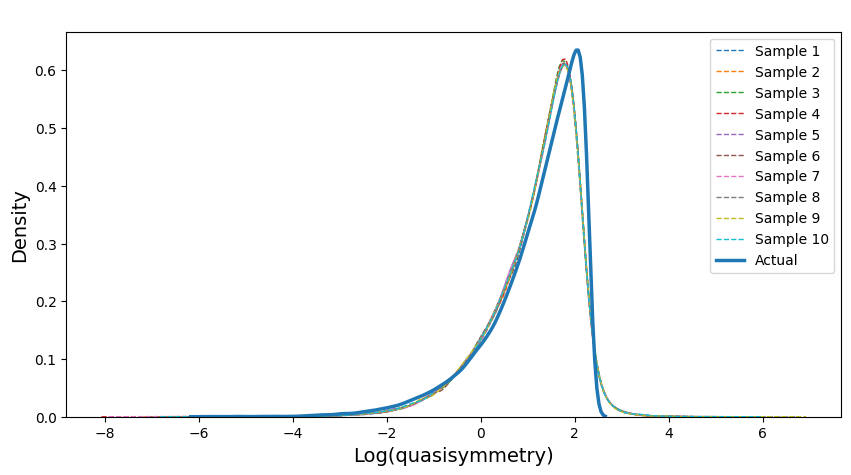

In [5]:
n_subset = 10
#pred_df = pred_samples.iloc[:, 0:n_subset]
pred_df = pred_samples[pred_samples.columns.to_series().sample(n_subset)]
pred_df.columns = [f"Sample {i+1}" for i in range(n_subset)]

# Convert the pandas Series to a NumPy array and reshape it
actual_df = pd.DataFrame(test_target_no_outliers.values.reshape(-1,), columns=["Actual"])

plot_df = pd.concat([pred_df, actual_df], axis=1)
linestyles = ["--" for _ in range(n_subset)] + ["solid"]
linewidths = [1 for _ in range(n_subset)] + [2.5]

plt.figure(figsize=figure_size)
for idx, col in enumerate(plot_df.columns):
    sns.kdeplot(plot_df[col], linestyle=linestyles[idx], lw=linewidths[idx], label=col)
plt.legend()
plt.title("  ")
plt.gca().set_xlabel("Log(quasisymmetry)", fontsize = 14)
plt.gca().set_ylabel("Density", fontsize = 14)
plt.show()


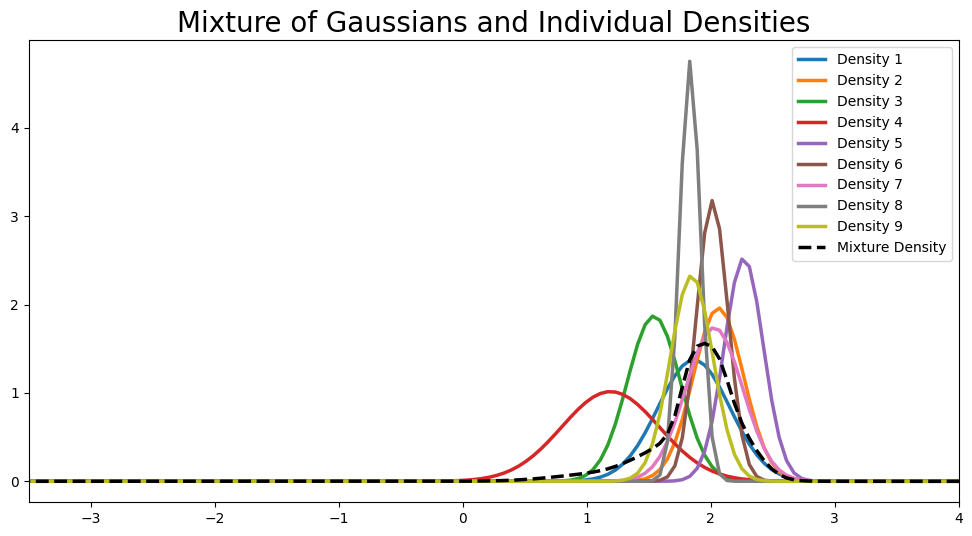

Weights for each Gaussian component:
Weight for Gaussian 1: 0.0939
Weight for Gaussian 2: 0.0942
Weight for Gaussian 3: 0.0936
Weight for Gaussian 4: 0.0936
Weight for Gaussian 5: 0.0938
Weight for Gaussian 6: 0.2499
Weight for Gaussian 7: 0.0936
Weight for Gaussian 8: 0.0936
Weight for Gaussian 9: 0.0936


In [6]:
from scipy.stats import norm  # Importing norm for Gaussian density calculation

mix_params = torch.split(torch.tensor(pred_params.values[0, :]).reshape(1, -1), lgblss.dist.M, dim=1)
mix_params[1][0][0] = mix_params[1][0][0] + torch.tensor(0.1)  # Increase the std of the first density for plotting reasons

# Create Mixture-Distribution
torch.manual_seed(123)
mix_dist = lgblss.dist.create_mixture_distribution(mix_params)
gaus_dist = mix_dist._component_distribution
gaus_samples = pd.DataFrame(
    gaus_dist.sample((test_target_no_outliers.shape[0],)).reshape(-1, lgblss.dist.M).numpy(),
    columns=[f"Density {i + 1}" for i in range(lgblss.dist.M)]
)

# Extract means, stds, and weights from mix_params
means = mix_params[0][0].detach().numpy()
stds = mix_params[1][0].detach().numpy()
weights = torch.nn.functional.softmax(mix_params[2][0], dim=0).detach().numpy()  # Assuming the last split part contains the weights logits

# Define a range for the x-axis
x = np.linspace(-10, 50, 1000)

# Plot individual Gaussian densities
plt.figure(figsize=(12, 6))
for i in range(lgblss.dist.M):
    y = norm.pdf(x, loc=means[i], scale=stds[i])
    sns.lineplot(x=x, y=y, lw=2.5, label=f"Density {i + 1}")

# Calculate and plot mixture density
mixture_density = np.zeros_like(x)
for i in range(lgblss.dist.M):
    mixture_density += weights[i] * norm.pdf(x, loc=means[i], scale=stds[i])

sns.lineplot(x=x, y=mixture_density, lw=2.5, color='k', label='Mixture Density', linestyle='--')

plt.title("Mixture of Gaussians and Individual Densities", fontsize=20)
plt.legend()
plt.xlim(-3.5, 4)
plt.show()

# Print the weights for each Gaussian
print("Weights for each Gaussian component:")
for i, w in enumerate(weights):
    print(f"Weight for Gaussian {i + 1}: {w:.4f}")

In [7]:
pred_samples.median(axis=1)

0        2.012813
1        1.108120
2        0.660322
3        1.862383
4        1.683895
           ...   
47685    1.767585
47686   -0.125373
47687    0.344755
47688    1.376712
47689    0.187886
Length: 47690, dtype: float32

Predicted medians calculated


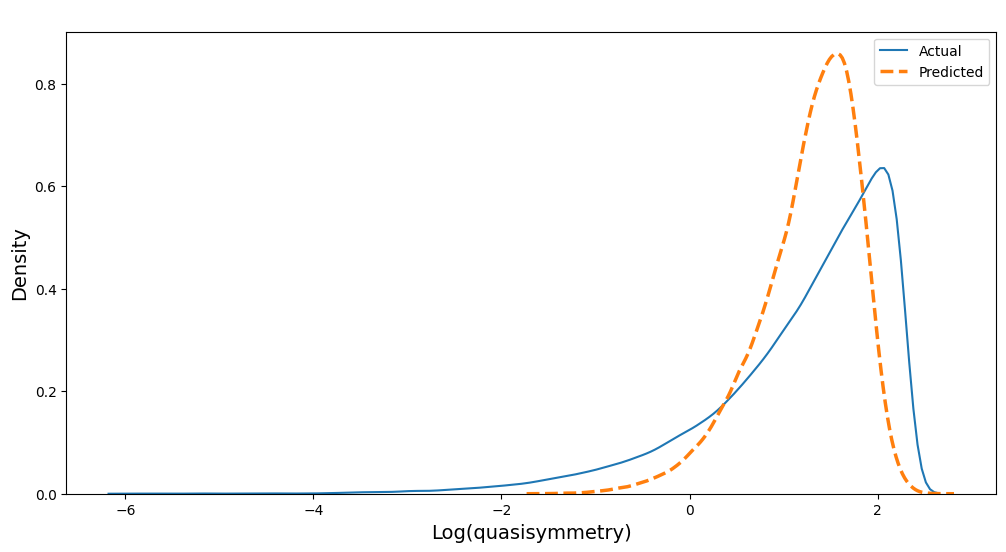

In [9]:
pred_medians = pred_samples.median(axis=1)
print('Predicted medians calculated')

actual_df = pd.DataFrame(test_target_no_outliers.values, columns=["Actual"])
median_df = pd.DataFrame(pred_medians.values, columns=["Median Predicted"])

plot_df = pd.concat([actual_df, median_df], axis=1)

# Plot the density estimation
plt.figure(figsize=(12, 6))
sns.kdeplot(plot_df["Actual"], label="Actual", linestyle="solid", lw=1.5)
sns.kdeplot(plot_df["Median Predicted"], label="Predicted", linestyle="--", lw=2.5)
plt.legend()
plt.title("  ")
plt.xlabel("Log(quasisymmetry)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.savefig('10predicted_densities.pdf')
plt.show()

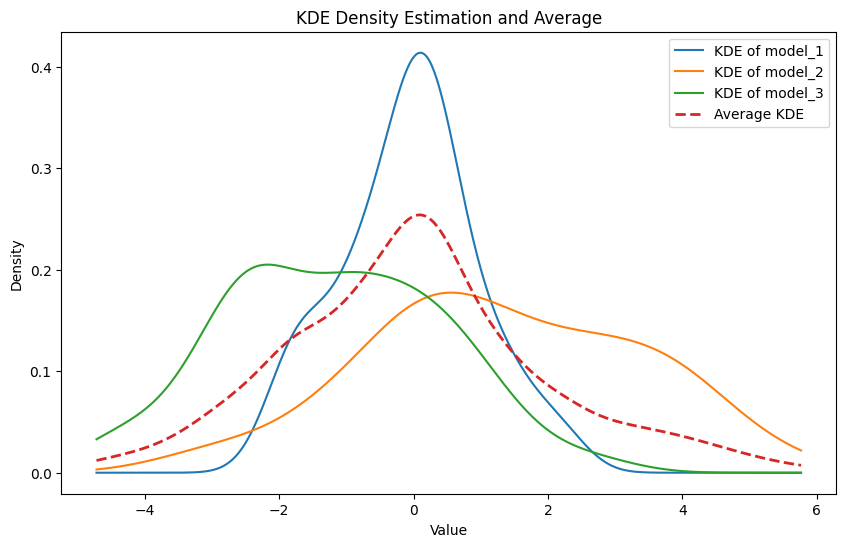

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming your DataFrame is named df
df = pd.DataFrame({
    'model_1': np.random.normal(0, 1, 100),
    'model_2': np.random.normal(1, 2, 100),
    'model_3': np.random.normal(-1, 1.5, 100)
})

# Define a common grid
x_grid = np.linspace(df.values.min(), df.values.max(), 1000)

# Calculate KDE for each column
kde_estimates = []
for column in df.columns:
    kde = gaussian_kde(df[column])
    kde_estimates.append(kde(x_grid))

# Convert to numpy array for easier averaging
kde_estimates = np.array(kde_estimates)

# Average the KDEs
average_kde = np.mean(kde_estimates, axis=0)

# Plot the result
plt.figure(figsize=(10, 6))
for i, column in enumerate(df.columns):
    plt.plot(x_grid, kde_estimates[i], label=f'KDE of {column}')
plt.plot(x_grid, average_kde, label='Average KDE', linewidth=2, linestyle='--')
plt.legend()
plt.title('KDE Density Estimation and Average')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


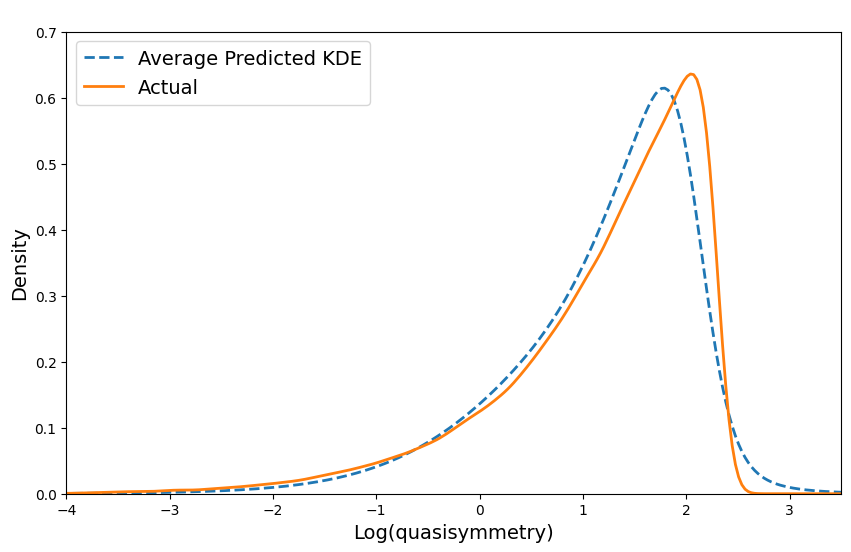

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x_grid = np.linspace(pred_samples.values.min(), pred_samples.values.max(), 800)
pred_columns = pred_samples.columns.to_series().sample(2000)
# Calculate KDE for each column
kde_estimates = []
for column in pred_columns:
    kde = gaussian_kde(pred_samples[column])
    kde_estimates.append(kde(x_grid))

# Convert to numpy array for easier averaging
kde_estimates = np.array(kde_estimates)

# Average the KDEs
average_kde = np.mean(kde_estimates, axis=0)

actual_df = pd.DataFrame(test_target_no_outliers.values.reshape(-1,), columns=["Actual"])

kde = gaussian_kde(actual_df['Actual'].values)
kde_actual_estimates = kde(x_grid)

# Convert to numpy array for easier averaging
kde_actual_estimates = np.array(kde_actual_estimates)

# Plot the result
plt.figure(figsize=(10, 6))
#for i, column in enumerate(pred_columns):
#    plt.plot(x_grid, kde_estimates[i], label=f'KDE of {column}')
plt.plot(x_grid, average_kde, label='Average Predicted KDE', linewidth=2, linestyle='--')
plt.plot(x_grid, kde_actual_estimates, label='Actual', linewidth=2, linestyle='-')
plt.legend(fontsize = 14)
plt.title('  ')
plt.xlabel('Log(quasisymmetry)', fontsize = 14)
plt.xlim(-4, 3.5)
plt.ylabel('Density', fontsize = 14)
plt.ylim(0,0.7)
plt.savefig('10predicted_densities.pdf')
plt.show()

In [13]:
import numpy as np
import pandas as pd

# Assuming test_target_no_outliers is a Pandas Series or DataFrame column
counts = 0
log_five = np.log(5)

# If test_target_no_outliers is a Series
for value in test_target_no_outliers.values:
    if value > log_five:
        counts += 1

print(f"Number of stellarators with quasisymmetry > log(5): {counts}")

# Alternatively, you can use boolean indexing for a more concise solution
counts = (test_target_no_outliers > log_five).sum()
print(f"Number of stellarators with quasisymmetry > log(5): {counts}")


Number of stellarators with quasisymmetry > log(5): 20264
Number of stellarators with quasisymmetry > log(5): 20264
